### This notebook gives a quick overview of how groundwater properties have changed over the years in different wells. It focuses on three things: nitrate levels, temperature, and acidity.


In [7]:
import pandas as pd
from pathlib import Path
import csv

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import sys
import matplotlib.dates as mdates

In [3]:
#this root should be changed
root = Path("/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/data/DINOloket_water_chem/BRO_Grondwatermonitoring/BRO_Grondwatermonitoringput")

Here we reorganize the way data is stored. In original version on nitrate value per year is stored in a separate folder. To make it more convenient for EDA we have to combine these values in one csv file per well.

In [9]:
def process_year_csv(csv_path):
    text = Path(csv_path).read_text(encoding='utf-8', errors='replace')  # read lines
    lines = text.splitlines()

    meta = next(csv.reader([lines[1]]))
    bro_id       = meta[0].strip('"')
    time_str     = meta[3].strip('"')
    analysedatum = pd.to_datetime(
        time_str,
        dayfirst=True,
        infer_datetime_format=True,
        errors='coerce'
    )

    #helper to read a parameter‑block by finding its header
    def read_block(header_contains, cols_to_read):
        idx_h = next(
            i for i, L in enumerate(lines)
            if all(tok in L for tok in header_contains)
        )
        idx_b = next(i for i in range(idx_h+1, len(lines)) if lines[i].lstrip().startswith(','))
        df = pd.read_csv(
            csv_path,
            skiprows=idx_h,
            header=0,
            nrows=idx_b - idx_h - 1,
            usecols=cols_to_read,
            encoding='utf-8'
        )
        return df

    #read "value" and "unit of measurment" columns
    df1 = read_block(
        header_contains=['"analysemeetwaarde"', '"eenheid meetwaarde"'],
        cols_to_read=['parameter', 'analysemeetwaarde']
    ).dropna(subset=['parameter'])
    phys = df1.set_index('parameter')['analysemeetwaarde']

    # read "date" + "value"
    df2 = read_block(
        header_contains=['"analysedatum"', '"analysemeetwaarde"'],
        cols_to_read=['parameter', 'analysemeetwaarde']
    ).dropna(subset=['parameter'])
    nut  = df2.set_index('parameter')['analysemeetwaarde']

    return pd.Series({
        'nitraat'      : nut.get('nitraat',    pd.NA),
        'fosfaat'      : nut.get('fosfaat',    pd.NA),
        'Temperatuur'  : phys.get('Temperatuur',pd.NA),
        'Zuurgraad'    : phys.get('Zuurgraad',  pd.NA),
        'BroID'        : bro_id,
        'analysedatum' : analysedatum
    })

In [ ]:
#create new files with combined data per well
for well_dir in root.iterdir():
    if not (well_dir.is_dir() and well_dir.name.startswith("GMW")):
        continue

    rows = []
    for csv_path in sorted(well_dir.glob("*.csv")):
        try:
            rows.append(process_year_csv(csv_path))
        except Exception as e:
            print(f"Skipping {csv_path.name}: {e}")

    if not rows:
        continue

    combined = pd.DataFrame(rows)
    combined.to_csv(f"{well_dir.name}_combined.csv", index=False)

Quick stats overview of data

In [5]:
file_path = "/Users/Administrator/Documents/University/Year 3/2b/Thesis/notebooks/GMW000000038539_combined.csv"
df = pd.read_csv(file_path)

is_sorted = df["analysedatum"].is_monotonic_increasing

missing_values = df[["nitraat", "Temperatuur", "Zuurgraad"]].isna().sum() # check for missing values
summary_stats = df[["nitraat", "Temperatuur", "Zuurgraad"]].describe()

is_sorted, missing_values, summary_stats

(False,
 nitraat        0
 Temperatuur    0
 Zuurgraad      0
 dtype: int64,
          nitraat  Temperatuur  Zuurgraad
 count  27.000000    27.000000  27.000000
 mean    0.377815    10.844444   7.083704
 std     0.532011     1.257388   0.149129
 min     0.014000     9.200000   6.860000
 25%     0.029500     9.700000   6.985000
 50%     0.070000    10.800000   7.090000
 75%     0.655500    11.400000   7.175000
 max     1.786000    14.700000   7.400000)

Plotting the variables through years

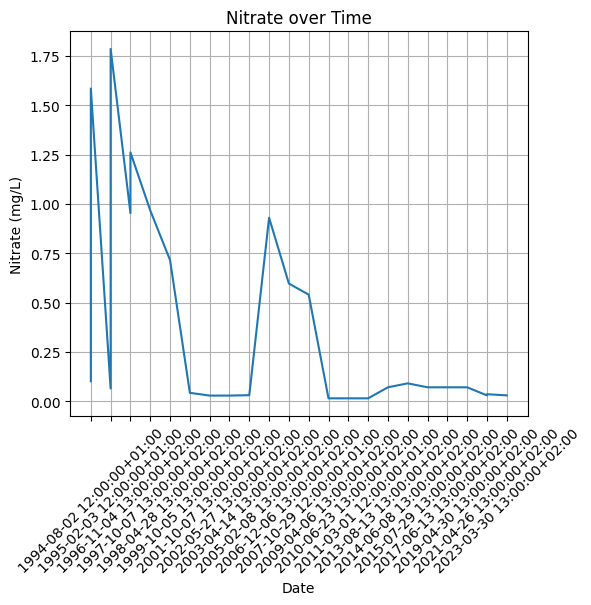

In [9]:
df_sorted = df.sort_values(by="analysedatum") # convert to datetime

# nitrate
plt.figure()
plt.plot(df_sorted["analysedatum"], df_sorted["nitraat"])
plt.title("Nitrate over Time")
plt.xlabel("Date")
plt.ylabel("Nitrate (mg/L)")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


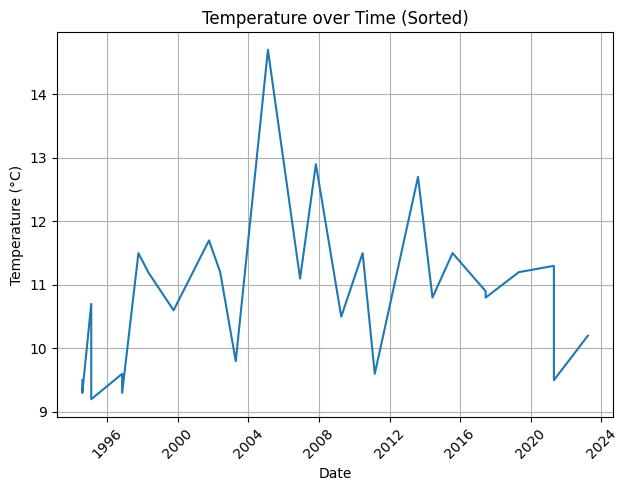

In [17]:
# Temperature
plt.figure()
plt.plot(df_sorted["analysedatum"], df_sorted["Temperatuur"])
plt.title("Temperature over Time (Sorted)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

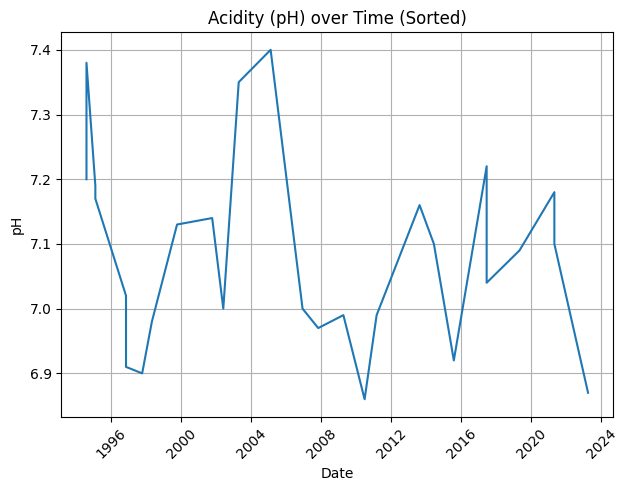

In [19]:
# Acidity (pH)
plt.figure()
plt.plot(df_sorted["analysedatum"], df_sorted["Zuurgraad"])
plt.title("Acidity (pH) over Time (Sorted)")
plt.xlabel("Date")
plt.ylabel("pH")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

/var/folders/fr/h0n611t55y51b_mts5q50l540000gn/T/ipykernel_20282/2856156800.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df["analysedatum"] = pd.to_datetime(df["analysedatum"])
/var/folders/fr/h0n611t55y51b_mts5q50l540000gn/T/ipykernel_20282/2856156800.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df["analysedatum"] = pd.to_datetime(df["analysedatum"])


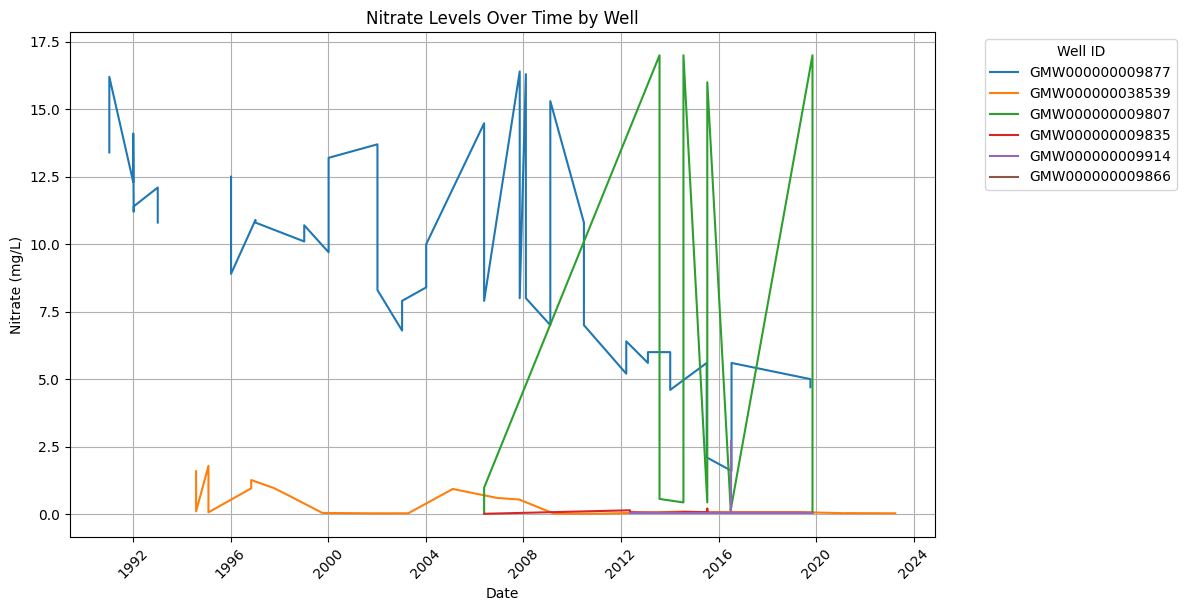

In [27]:
files = [
    "/Users/Administrator/Documents/University/Year 3/2b/Thesis/notebooks/GMW000000009807_combined.csv",
    "/Users/Administrator/Documents/University/Year 3/2b/Thesis/notebooks/GMW000000009835_combined.csv",
    "/Users/Administrator/Documents/University/Year 3/2b/Thesis/notebooks/GMW000000009866_combined.csv",
    "/Users/Administrator/Documents/University/Year 3/2b/Thesis/notebooks/GMW000000009877_combined.csv",
    "/Users/Administrator/Documents/University/Year 3/2b/Thesis/notebooks/GMW000000009914_combined.csv",
    "/Users/Administrator/Documents/University/Year 3/2b/Thesis/notebooks/GMW000000038539_combined.csv"
]

# Read and tag each DataFrame with the filename (as Well ID)
combined_data = []

for file in files:
    df = pd.read_csv(file)
    df["analysedatum"] = pd.to_datetime(df["analysedatum"])
    well_id = Path(file).stem.replace("_combined", "")
    df["WellID"] = well_id
    combined_data.append(df[["analysedatum", "nitraat", "WellID"]])

# Concatenate all into one DataFrame
df_all = pd.concat(combined_data).sort_values("analysedatum")

import matplotlib.pyplot as plt

# Plot nitrate levels per well
plt.figure(figsize=(12, 6))
for well in df_all["WellID"].unique():
    sub = df_all[df_all["WellID"] == well]
    plt.plot(sub["analysedatum"], sub["nitraat"], label=well)

plt.title("Nitrate Levels Over Time by Well")
plt.xlabel("Date")
plt.ylabel("Nitrate (mg/L)")
plt.legend(title="Well ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

/var/folders/fr/h0n611t55y51b_mts5q50l540000gn/T/ipykernel_20282/1996023993.py:4: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  sub_df["analysedatum"] = pd.to_datetime(sub_df["analysedatum"])
/var/folders/fr/h0n611t55y51b_mts5q50l540000gn/T/ipykernel_20282/1996023993.py:4: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  sub_df["analysedatum"] = pd.to_datetime(sub_df["analysedatum"])


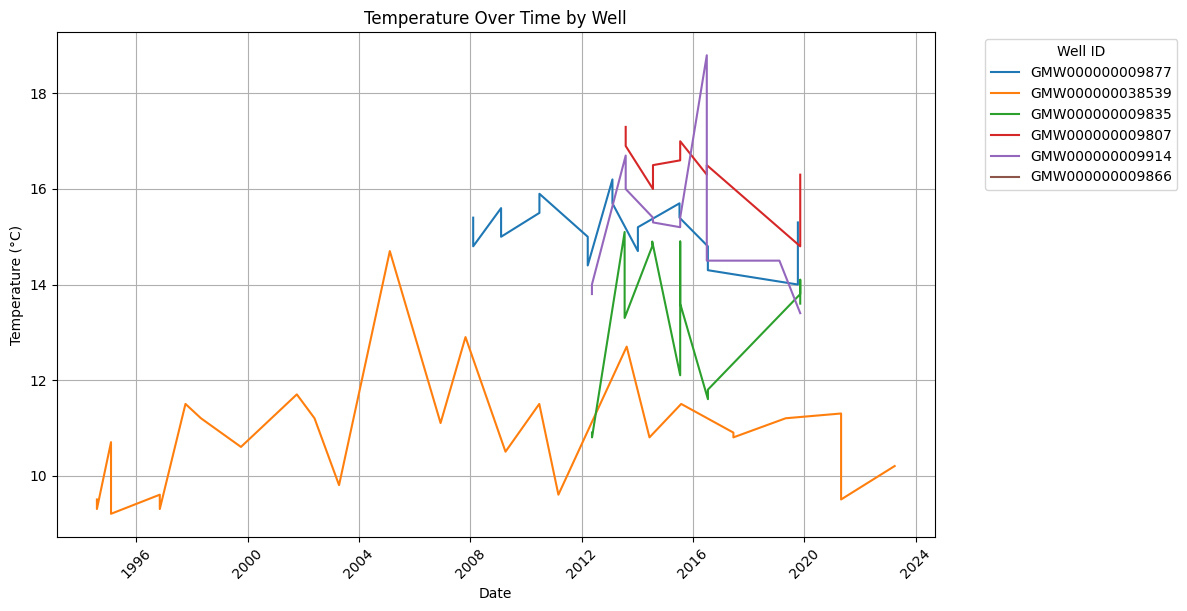

In [32]:
plt.figure(figsize=(12, 6))
for well in df_all["WellID"].unique():
    sub_df = pd.read_csv(f"/Users/Administrator/Documents/University/Year 3/2b/Thesis/notebooks/{well}_combined.csv")
    sub_df["analysedatum"] = pd.to_datetime(sub_df["analysedatum"])
    sub_df = sub_df.sort_values("analysedatum")
    plt.plot(sub_df["analysedatum"], sub_df["Temperatuur"], label=well)

plt.title("Temperature Over Time by Well")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend(title="Well ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

/var/folders/fr/h0n611t55y51b_mts5q50l540000gn/T/ipykernel_20282/1510769892.py:4: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  sub_df["analysedatum"] = pd.to_datetime(sub_df["analysedatum"])
/var/folders/fr/h0n611t55y51b_mts5q50l540000gn/T/ipykernel_20282/1510769892.py:4: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  sub_df["analysedatum"] = pd.to_datetime(sub_df["analysedatum"])


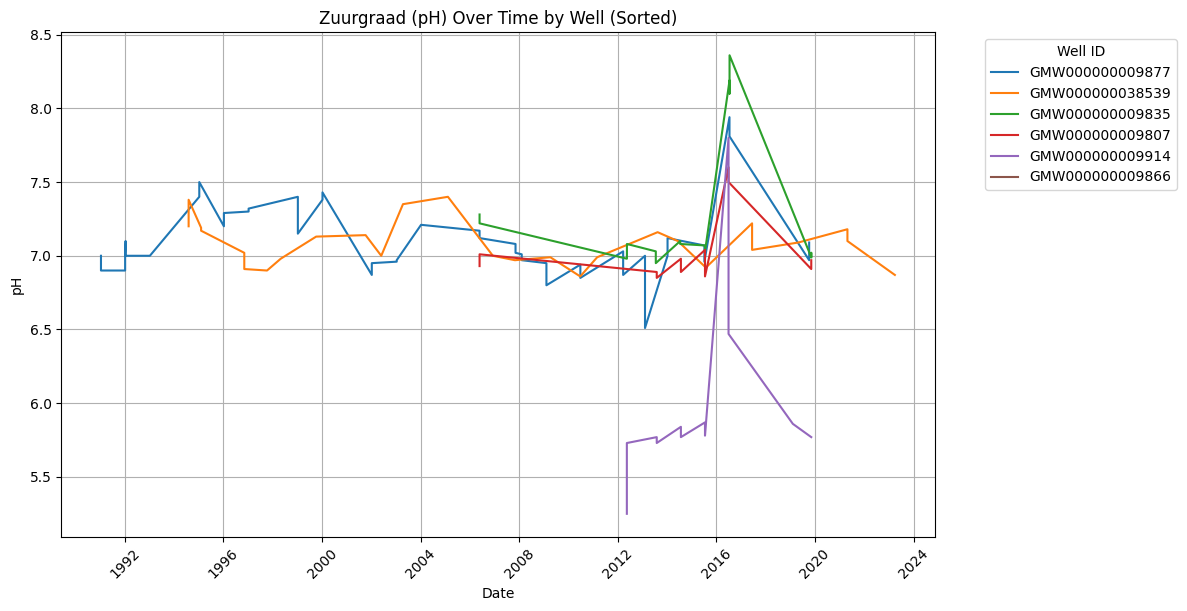

In [31]:
plt.figure(figsize=(12, 6))
for well in df_all["WellID"].unique():
    sub_df = pd.read_csv(f"/Users/Administrator/Documents/University/Year 3/2b/Thesis/notebooks/{well}_combined.csv")
    sub_df["analysedatum"] = pd.to_datetime(sub_df["analysedatum"])
    sub_df = sub_df.sort_values("analysedatum")
    plt.plot(sub_df["analysedatum"], sub_df["Zuurgraad"], label=well)

plt.title("Acidity (pH) Over Time by Well")
plt.xlabel("Date")
plt.ylabel("pH")
plt.legend(title="Well ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()